In [11]:
!wget https://codeload.github.com/Marek324/butfit-zre-labs/zip/refs/heads/master -O repo.zip
!unzip repo.zip "butfit-zre-labs-master/*" -d repo
!mv repo/butfit-zre-labs-master/* .
!rm -rf repo.zip repo *.md cv*

--2025-05-17 14:41:07--  https://codeload.github.com/Marek324/butfit-zre-labs/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘repo.zip’

repo.zip                [      <=>           ]  18.34M  12.6MB/s    in 1.5s    

2025-05-17 14:41:09 (12.6 MB/s) - ‘repo.zip’ saved [19235443]

Archive:  repo.zip
878ce558ff3d270995d1a0ea4e2a8a3362b8a6d6
   creating: repo/butfit-zre-labs-master/
 extracting: repo/butfit-zre-labs-master/.gitignore  
 extracting: repo/butfit-zre-labs-master/.python-version  
  inflating: repo/butfit-zre-labs-master/.venv_req.txt  
 extracting: repo/butfit-zre-labs-master/README.md  
   creating: repo/butfit-zre-labs-master/audio/
  inflating: repo/butfit-zre-labs-master/audio/buongiorno16.wav  
  inflating: repo/butfit-zre-labs-master/audio/michia

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal as sg
import scipy.stats as sts
import zre_lib
import librosa
import soundfile as sf
import importlib
import os
from IPython.display import Audio
from tqdm import tqdm
import pandas as pd
import re

# Practicals 4: Classification and Gaussian Mixture Models


## Ex. 1 Gaussian distributions 1D
Let's classify data using statistical classifiers based on modelling data using Gaussian distributions.

### 1.1 Create two sets of gaussian distributions and save a dataset txt file

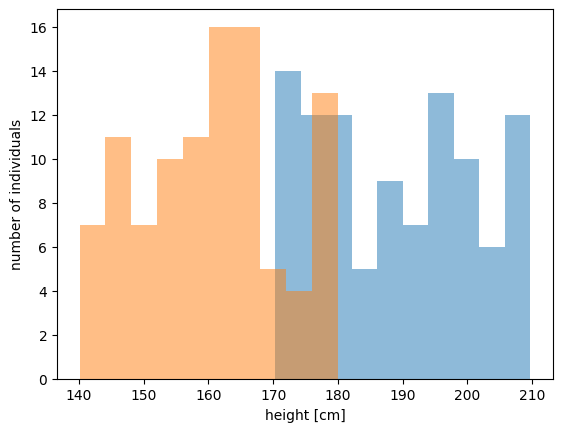

In [13]:
# generate 2 training samples with 100 values
data1 = np.random.rand(100) * (210-170) + 170 # big people
data2 = np.random.rand(100) * (180-140) + 140 # small people

plt.figure()
plt.hist(data1, bins=10, alpha=0.5)
plt.hist(data2, bins=10, alpha=0.5)
plt.xlabel("height [cm]")
plt.ylabel("number of individuals")
plt.show()

data_str = []
f = open('velcimali_train.txt', 'w')
for d in data1:
    data_str.append(f'{d} 1')
for d in data2:
    data_str.append(f'{d} 2')
for d in np.random.permutation(data_str):
    print(f'{d}', file=f)
f.close()



Vygenerovaná data zapíšeme do souboru. Dále si vytvoříme dvě sady 50 testovacích vzorků, generujeme ze stejného rozložení:

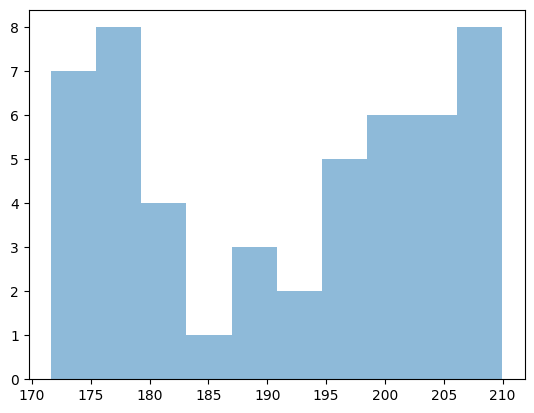

In [14]:
# generate testing samples
data1 = np.random.rand(50) * (210-170) + 170  # big people
data2 = np.random.rand(50) * (180-140) + 140  # small people

plt.figure()
plt.hist(data1, bins=10, alpha=0.5)
plt.show()

data_str = []
f = open('velcimali_test.txt', 'w')
for d in data1:
    data_str.append(f'{d} 1')
for d in data2:
    data_str.append(f'{d} 2')
for d in np.random.permutation(data_str):
    print(f'{d}', file=f)
f.close()

### 1.2 Train and test a single Gaussian model based on your dataset
The probability density function (PDF) of the Normal distribution is given by the formula:
$$
\mathcal{N}\left(x|\mu,\sigma^2\right) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}}
$$

In python we can use the function scipy.stats.norm.pdf https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html



#### Q: How can we estimate the mean $\mu$ and variance (std) $\sigma^2$ values?

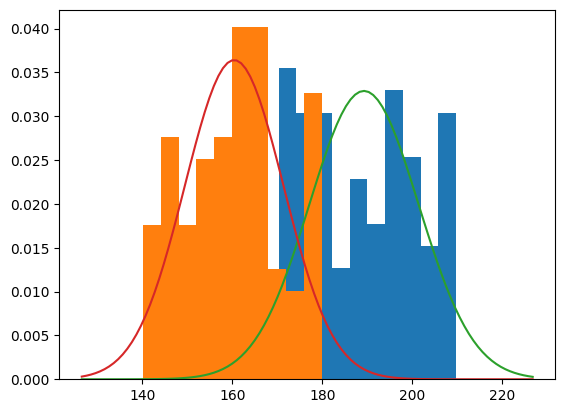

In [15]:
# read data
aux = np.loadtxt('velcimali_train.txt')
data = aux[:, 0]
classes = aux[:, 1]

data1 = data[classes==1]
data2 = data[classes==2]

m1, s1 = data1.mean(), data1.std()
m2, s2 = data2.mean(), data2.std()


plt.figure()
plt.hist(data1, bins=10, density=True)
plt.hist(data2, bins=10, density=True)

rv1 = sts.norm(m1, s1)
rv2 = sts.norm(m2, s2)
x = np.linspace(rv2.ppf(0.001),
                rv1.ppf(0.999), 100)
plt.plot(x, rv1.pdf(x))
plt.plot(x, rv2.pdf(x))
plt.show()


#### Q: What does the rv2(0.999) command return?

#### Q: What does the std (s1,s2) values reflect? How should we change the values to make s1 greater?

In [18]:
rv2.ppf(0.999)

np.float64(194.2756099752426)

Now we can test the model using our testing data.
#### 1.2.1 Calculate the scores based on the Gaussian model for every sample

In [16]:
# Load test data
aux = np.loadtxt('velcimali_test.txt')
aux[0:5]

array([[199.20033048,   1.        ],
       [208.62442538,   1.        ],
       [171.34235916,   2.        ],
       [145.984539  ,   2.        ],
       [174.52006927,   2.        ]])

In [19]:
data = aux[:, 0]
classes = aux[:, 1]
scores = np.zeros_like(data)
s1 = rv1.pdf(data)
s2 = rv2.pdf(data)
scores = s1 - s2

#### Q: What is s1,s2? How it will look like if we sort tha data? And the scores?

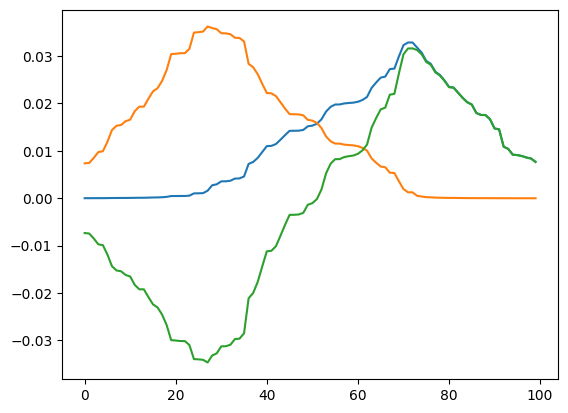

In [22]:
plt.plot(s1[np.argsort(data)])
plt.plot(s2[np.argsort(data)])
plt.plot(scores[np.argsort(data)])
# plt.plot(np.where(scores[np.argsort(data)] > 0, 1, 2))

#### 1.2.2 Classify the data based on the scores and compare them with the actual class

#### Q: How should we make the classification decision?


In [24]:
def eval_2_class(scores, classes):
    N = len(scores)
    decisions = np.where(scores > 0, 1, 2)
    correct = sum(decisions == classes)
    error12 = sum(((decisions == 1) & (classes == 2)))
    error21 = sum(((decisions == 2) & (classes == 1)))
    error = error12 + error21
    acc = correct / N
    errrate = error / N
    print(f'N = {N}, correct = {correct}, error12 = {error12}, error21 = {error21}')
    print(f'accuracy = {acc*100} err.rate = {errrate*100}')
    return (decisions, acc, errrate)

N = 100, correct = 90, error12 = 4, error21 = 6
accuracy = 90.0 err.rate = 10.0


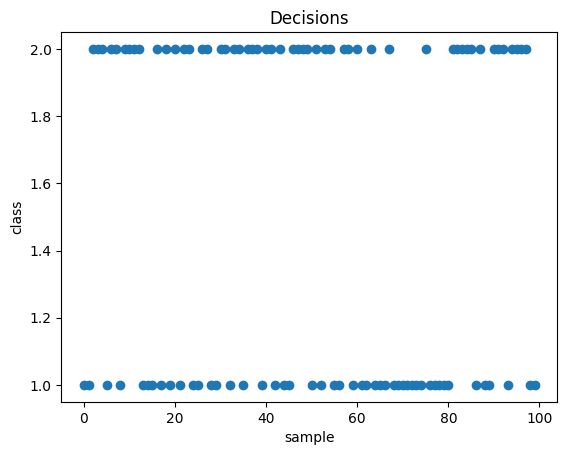

In [25]:
decisions, acc, errrate = eval_2_class(scores, classes)
plt.title("Decisions")
plt.ylabel("class")
plt.xlabel("sample")
plt.scatter(np.arange(len(decisions)), decisions)


### 1.3 Multimodal distribution (1D)
Let's now try to classify people having abnormal pressure values (high and low) and healthy people.
Consider the following pressure values:
- 40,70: low pressure - abnormal
- 60-90: normal pressure
- 80-170: high pressure -abnormal

We have two classes:
1) Healthy: normal pressure values
2) Unhealthy: low and high --> MULTIMODAL distribution


#### 1.3.1 Generate train and test data for these classes with 500 samplese each.
Save the datasets as text files

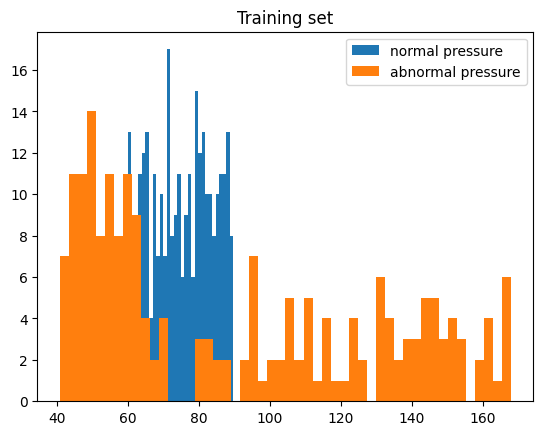

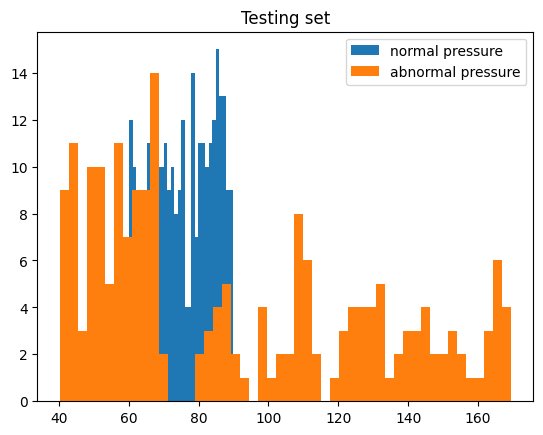

In [26]:
if True:
    data1 = np.random.rand(300) * (90-60) + 60  # normal
    data2 = np.random.rand(100) * (70-40) + 40  # low
    data2 = np.concatenate([data2, np.random.rand(100) * (170-80) + 80])
else:
    data1 = sts.norm.rvs(loc=np.mean([90,60]), scale=30/4, size=300) # normal
    data2 = sts.norm.rvs(loc=np.mean([70,40]), scale=30/4, size=100)  # low
    data2 = np.concatenate([data2, sts.norm.rvs(loc=np.mean([170,80]), scale=90/4, size=100)])

plt.figure()
plt.title("Training set")
plt.hist(data1, bins=30, label = "normal pressure")
plt.hist(data2, bins=50, label = "abnormal pressure")
plt.legend()
plt.show()

data_str = []
for d in data1:
    data_str.append(f'{d} 1')
for d in data2:
    data_str.append(f'{d} 2')
f = open('zdravinemocni_train.txt', 'w')
for d in np.random.permutation(data_str):
    print(f'{d}', file=f)
f.close()

data1 = np.random.rand(300) * (90-60) + 60  # normal
data2 = np.random.rand(100) * (70-40) + 40  # low
data2 = np.concatenate([data2, np.random.rand(100) * (170-80) + 80])

plt.figure()
plt.title("Testing set")
plt.hist(data1, bins=30,label = "normal pressure")
plt.hist(data2, bins=50,label = "abnormal pressure")
plt.legend()
plt.show()

data_str = []
for d in data1:
    data_str.append(f'{d} 1')
for d in data2:
    data_str.append(f'{d} 2')
f = open('zdravinemocni_test.txt', 'w')
for d in np.random.permutation(data_str):
    print(f'{d}', file=f)
f.close()

#### 1.3.2 Train a classifier with two gaussians (unimodal) as in 1.2.

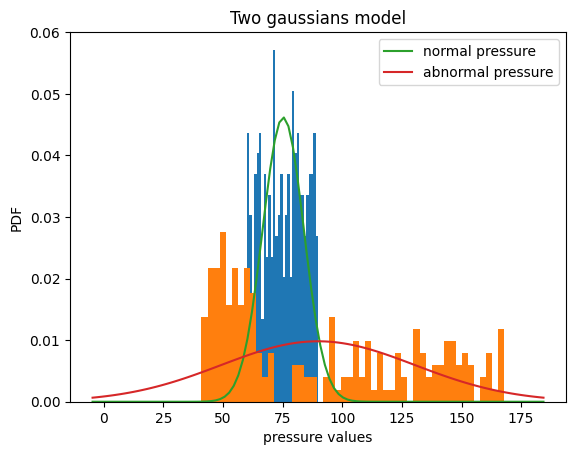

In [27]:
# read data
aux = np.loadtxt('zdravinemocni_train.txt')
data = aux[:, 0]
classes = aux[:, 1]

data1 = data[classes==1]
data2 = data[classes==2]

m1, s1 = data1.mean(), data1.std()
m2, s2 = data2.mean(), data2.std()


plt.figure()
plt.hist(data1, bins=30, density=True)
plt.hist(data2, bins=50, density=True)

rv1 = sts.norm(m1, s1)
rv2 = sts.norm(m2, s2)
x = np.linspace(rv2.ppf(0.01),
                rv2.ppf(0.99), 100)
plt.plot(x, rv1.pdf(x),label="normal pressure")
plt.title("Two gaussians model")
plt.plot(x, rv2.pdf(x), label ="abnormal pressure")
plt.legend()
plt.xlabel("pressure values")
plt.ylabel("PDF")
plt.show()



#### Q: How does the model look like? Does it model the datasets correctly?

Let's test it now.

In [28]:
aux = np.loadtxt('zdravinemocni_test.txt')
data = aux[:, 0]
classes = aux[:, 1]
s1 = rv1.pdf(data)
s2 = rv2.pdf(data)
scores = s1 - s2


In [29]:
decisions, acc, err = eval_2_class(scores, classes)

N = 500, correct = 445, error12 = 55, error21 = 0
accuracy = 89.0 err.rate = 11.0


#### Q: how come error21 = 0? Is it ok? How could we improve it?

#### 1.3.3  Multi-modal classification of healthy and unhealthy people
We have two modes in the second class - let's try to use a multimodal distribution then.
Mixture - group of gaussians
Component - one gaussian
We need to use two components, each of them with weights $w = 0.5$ (the sum of the weights must be 1)
The score of the mixture is calculated as follows:
$$
p(x|M) =\sum^C_{c=1}w_c p(x|\mu_c,\sigma^2_c)$$
$$ \sum_{c=1}^C w_c= 1
$$
We have two classes, so we need two mixtures, each of them with two gaussians.

Consider the following pressure values:
-  40,70: low pressure - abnormal
- 60-90: normal pressure
- 80-170: high pressure -abnormal



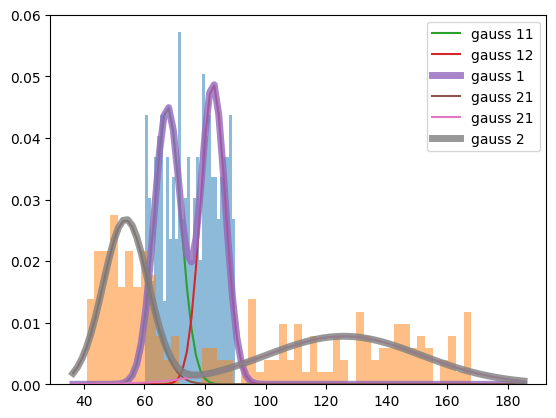

N = 500, correct = 435, error12 = 51, error21 = 14
accuracy = 87.0 err.rate = 13.0


In [30]:
# load train data
aux = np.loadtxt('zdravinemocni_train.txt')
data = aux[:, 0]
classes = aux[:, 1]

data1 = data[classes==1]
data2 = data[classes==2]

# separate the data classes into two parts and calculate means and stds.
data = data1[data1 < 75]
m11, s11, w11 = data.mean(), data.std(), 0.5
data = data1[data1 >= 75]
m12, s12, w12 = data.mean(), data.std(), 0.5
data = data2[data2 < 75]
m21, s21, w21 = data.mean(), data.std(), 0.5
data = data2[data2 >= 75]
m22, s22, w22 = data.mean(), data.std(), 0.5


# drawing
plt.figure()
plt.hist(data1, bins=30, density=True, alpha = 0.5)
plt.hist(data2, bins=50, density=True, alpha = 0.5)

rv11 = sts.norm(m11, s11)
rv12 = sts.norm(m12, s12)
rv21 = sts.norm(m21, s21)
rv22 = sts.norm(m22, s22)

x = np.linspace(rv21.ppf(0.01),
                rv22.ppf(0.99), 100)
plt.plot(x, w11*rv11.pdf(x), label='gauss 11')
plt.plot(x, w12*rv12.pdf(x), label='gauss 12')
plt.plot(x, w11*rv11.pdf(x)+w12*rv12.pdf(x), label='gauss 1', linewidth=5, alpha = 0.8)
plt.plot(x, w21*rv21.pdf(x), label='gauss 21')
plt.plot(x, w22*rv22.pdf(x), label='gauss 21')
plt.plot(x, w21*rv21.pdf(x)+w22*rv22.pdf(x), label='gauss 2', linewidth=5, alpha = 0.8)
plt.legend()
plt.show()

aux = np.loadtxt('zdravinemocni_test.txt')
data = aux[:, 0]
classes = aux[:, 1]
s1 = w11*rv11.pdf(data)+w12*rv12.pdf(data)
s2 = w21*rv21.pdf(data)+w22*rv22.pdf(data)
scores = s1 - s2
dedc, acc, err = eval_2_class(scores, classes)

#### Q: Is this distribution better? Why? How could it be improved?

## Ex. 2   Classifications of N dimensional data

Let's use the discovered methods for gender speaker recognition.


### 2.1 Load the data

In [31]:
datadir = './04_classif/GENDER_ID/data/male/train'
files = next(os.walk(datadir))[2]
males = []
idx = 0
for f in tqdm(files):
    s, Fs = sf.read(os.path.join(datadir, f), channels=1, samplerate=8000,
                    format='RAW', subtype='PCM_16')
    males.append(s)
print("Loaded speech signals: len(males) = %s" % len(males))

100%|██████████| 150/150 [00:00<00:00, 5775.05it/s]

Loaded speech signals: len(males) = 150


### 2.2 Calculate MFCC coefficients of each audio


#### Q: What are MFCC coefficients used for? How are they calculated?



In [32]:
for signal in males:
    # calculate the complex spectra - how may fft coefficients? Nfft value
    Nfft = 256
    stft = librosa.stft(signal, n_fft=Nfft, hop_length=80, win_length=200, center=False)

    # prepare the Mel filter bank - how many filters? Nbank value
    Nbanks = 8
    mel_filters = librosa.filters.mel(sr = Fs, n_fft = Nfft, n_mels = Nbanks, fmin = 32)

    # filter the signal (multiplication in frequency domain)
    mel_sp = np.matmul((np.abs(stft)**2).T, mel_filters.T)
    librosa_mel_sp = librosa.feature.melspectrogram(y = signal, sr = Fs, n_mels = Nbanks, n_fft = Nfft, hop_length = 80, win_length = 200, center = False, fmin = 32)

    # calculate the discrete cosine transform of the powers - how many cepstral coefficients? Nceps
    Nceps = 12
    dct_bank = scipy.fft.dct(np.eye(Nbanks))[:Nceps]

    mel_sp_db = 10*np.log10(np.abs(mel_sp+1e-10))
    mfccs = mel_sp_db @ dct_bank.T

    librosa_mfcc = librosa.feature.mfcc(y = signal, sr =  Fs, n_mfcc = Nceps, n_mels = Nbanks, n_fft = Nfft, win_length = 200, hop_length = 80, norm ="ortho", fmin = 32, center = False)


#### Q: What is dct_bank?

Discrete Cosine transform:
$$y_k = 2\displaystyle\sum_{n = 0}^{N-1}x_n \cos\Big(\displaystyle\frac{\pi k(2n+1)}{2N}\Big)$$
$$ y_k = \text{np.dot}(x, cos_k)

#### Q: How many frames does the filtered signal have?

Text(0, 0.5, 'freq [Hz]')

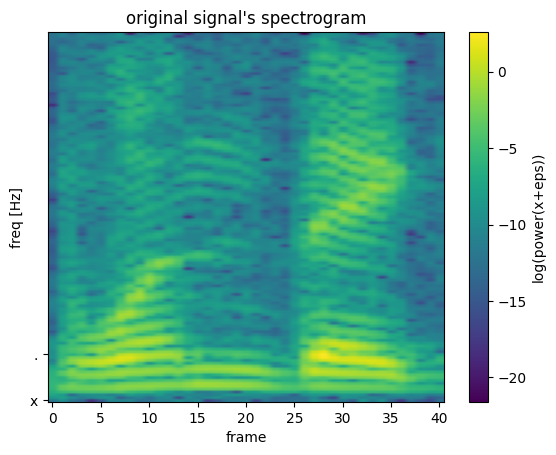

In [33]:
plt.imshow(np.log(np.abs(stft+0.0001)**2), aspect = "auto", origin = "lower")
plt.title("original signal's spectrogram")
plt.colorbar(label = "log(power(x+eps))")
plt.xlabel("frame")
plt.yticks(ticks = np.arange(0,len(f),16), labels = f[::16])
plt.ylabel("freq [Hz]")

Text(0, 0.5, 'Mel band (Nbanks)')

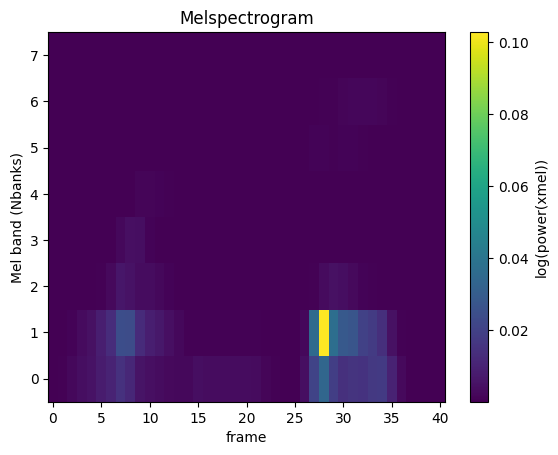

In [34]:
plt.imshow(mel_sp.T, aspect = "auto", origin = "lower")
plt.title("Melspectrogram")
plt.colorbar(label = "log(power(xmel))")
plt.xlabel("frame")
plt.ylabel("Mel band (Nbanks)")

Text(0, 0.5, 'Mel band (Nbanks)')

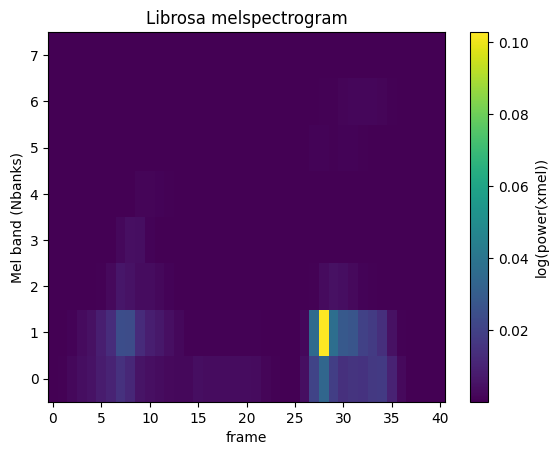

In [35]:
plt.imshow(librosa_mel_sp, aspect = "auto", origin = "lower")
plt.title("Librosa melspectrogram")
plt.colorbar(label = "log(power(xmel))")
plt.xlabel("frame")
plt.ylabel("Mel band (Nbanks)")

Text(0, 0.5, 'MFCC')

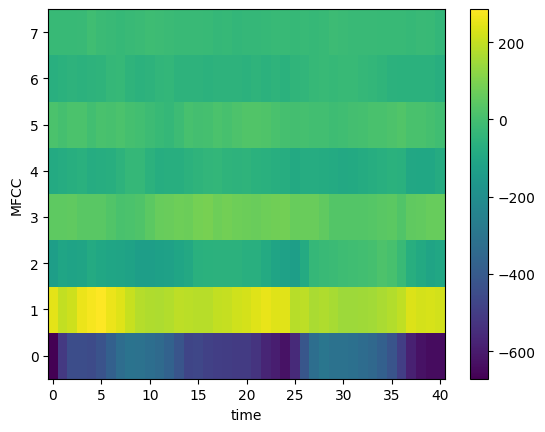

In [36]:
plt.imshow(mfccs.T, origin = "lower", aspect = "auto")
plt.colorbar()
plt.xlabel("time")
plt.ylabel("MFCC")

Text(0, 0.5, 'MFCC')

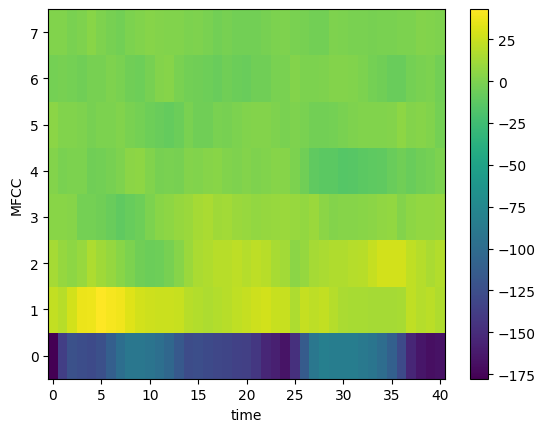

In [37]:
plt.imshow(librosa_mfcc, origin = "lower", aspect = "auto")
plt.colorbar()
plt.xlabel("time")
plt.ylabel("MFCC")

In [38]:
def mfcc(s, nfft=256, Fs=8000, window=200, noverlap=120, nbanks=23, nceps=12):
    """
    MFCC Mel Frequency Cepstral Coefficients
    cps = mfcc(s, FFTL, Fs, window, noverlap, nbanks, nceps)

    NFFT          - number of frequency points used to calculate the discrete
                  Fourier transforms
    Fs            - sampling frequency [Hz]
    window        - window lentgth for frame (in samples)
    noverlap      - overlapping between frames (in samples)
    nbanks        - numer of mel filter bank bands
    nceps         - number of cepstral coefficients - the output dimensionality
    """
    s = s + 0.01*np.random.rand(s.shape[0]) - 0.005

    stft = librosa.stft(s, n_fft=Nfft, hop_length=window-noverlap, win_length=window, center=False)

    mel_filters = librosa.filters.mel(sr = Fs, n_fft = nfft, n_mels = nbanks, fmin = 32)

    mel_sp = np.matmul((np.abs(stft)).T, mel_filters.T)

    dct_bank = scipy.fft.dct(np.eye(nbanks))[:nceps]
    mel_sp_db = np.log(mel_sp+1e-10)
    cps = mel_sp_db @ dct_bank.T

    return cps.T


def raw2mfcc(datadir):
    files = next(os.walk(datadir))[2]
    mfccs = []
    idx = 0
    for f in tqdm(files):
        s, Fs = sf.read(os.path.join(datadir, f), channels=1, samplerate=8000,
                        format='RAW', subtype='PCM_16')
        if True:
            mfccs.append(mfcc(s, nfft = 256, Fs = Fs, window = 200, noverlap = 120, nbanks = 8, nceps = 12))

        else:
            mfccs.append(librosa.feature.mfcc(s,sr=Fs, n_mfcc=12, n_fft=256,
                                        win_length=200, hop_length=80,
                                        n_mels=23, dct_type=3, window='boxcar', norm=None,
                                        power=1.0, fmin=32,center=False))

    return mfccs, files

In [39]:
train_m = np.concatenate(raw2mfcc('./04_classif/GENDER_ID/data/male/train')[0], axis=1)
train_f = np.concatenate(raw2mfcc('./04_classif/GENDER_ID/data/female/train')[0], axis=1)

test_m, files_m = raw2mfcc('./04_classif/GENDER_ID/data/male/test')
test_f, files_f = raw2mfcc('./04_classif/GENDER_ID/data/female/test')

100%|██████████| 10/10 [00:00<00:00, 201.16it/s]


In [40]:
train_f.shape

(8, 4509)

### 2.2 Classify the MFCCs using single gaussians
The data are 8-dimensional, we need to use multivariate gaussians. The probability distribution has the following form:
$$
\mathcal{N}\left(\mathbf{x}|\mathbf{\mu},\mathbf{\Sigma}\right) = \frac{1}{(2\pi)^{D/2}\left|\mathbf{\Sigma}\right|^{1/2}}\exp(−\frac{1}{2}\left(\mathbf{x}−\mathbf{μ}\right)^T\mathbf{\Sigma}^{−1}\left(\mathbf{x}−\mathbf{μ}\right))
$$
D is the dimentionality of the data, $mu$ is the mean value and $sigma$ is the covariance matrix.



#### 2.2.1 Diagonal Covariance matrix

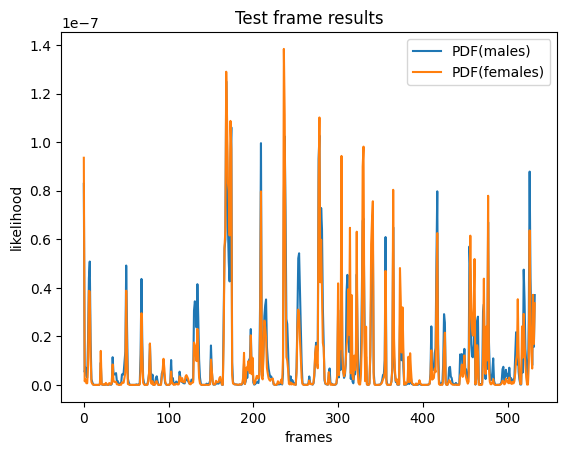

In [41]:
rv_m = sts.multivariate_normal(np.mean(train_m, axis=1), np.var(train_m, axis=1))
rv_f = sts.multivariate_normal(np.mean(train_f, axis=1), np.var(train_f, axis=1))

l_m = rv_m.pdf(test_m[0].T)
l_f = rv_f.pdf(test_m[0].T)

plt.figure()
plt.plot(l_m, label = "PDF(males)")
plt.plot(l_f, label="PDF(females)")
plt.xlabel('frames')
plt.ylabel('likelihood')
plt.title("Test frame results")
plt.legend()
plt.show()

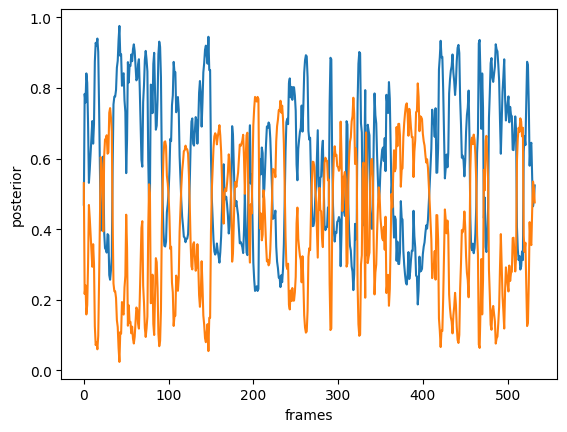

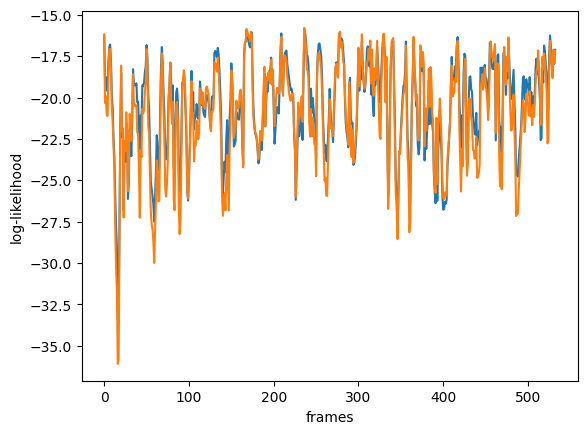

In [42]:
plt.figure()
plt.plot(l_m/(l_m+l_f))
plt.plot(l_f/(l_m+l_f))
plt.xlabel('frames')
plt.ylabel('posterior')
plt.show()

plt.figure()
plt.plot(np.log(l_m))
plt.plot(np.log(l_f))
plt.xlabel('frames')
plt.ylabel('log-likelihood')
plt.show()

### 2.3 Classify whole signals

We now want to classify the frames. The probability of the whole signal given the probability of each frame is given by:
$$p\left(\mathbf{x}_1,\mathbf{x}_2,\dots,\mathbf{x}_n\right) = p\left(\mathbf{x}_1\right)p\left(\mathbf{x}_2\right)\dots p\left(\mathbf{x}_n\right)$$
considering that each frame is generated independently.
In log domain:
$$ \log(p\left(\mathbf{x}_1,\mathbf{x}_2,\dots,\mathbf{x}_n\right)) = \sum_i\log(p(\mathbf{x}_i))



In [43]:
print(np.sum(np.log(l_m))-np.sum(np.log(l_f)))

251.54693095807488


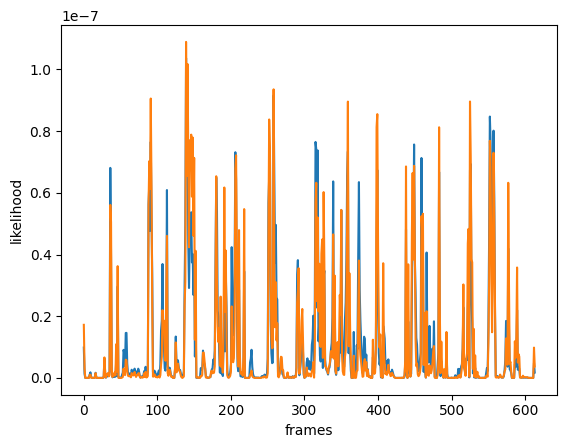

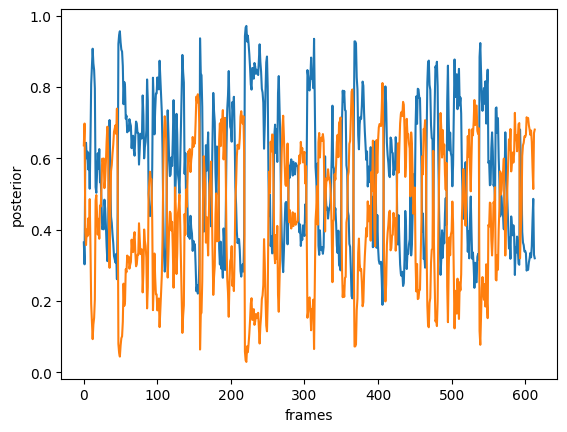

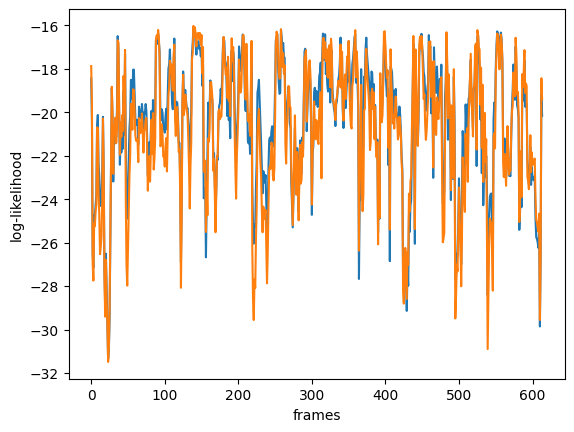

Score: 
197.47888355261603


In [44]:
l_m = rv_m.pdf(test_f[8].T)
l_f = rv_f.pdf(test_f[8].T)
plt.figure()
plt.plot(l_m)
plt.plot(l_f)
plt.xlabel('frames')
plt.ylabel('likelihood')
plt.show()

plt.figure()
plt.plot(l_m/(l_m+l_f))
plt.plot(l_f/(l_m+l_f))
plt.xlabel('frames')
plt.ylabel('posterior')
plt.show()

plt.figure()
plt.plot(np.log(l_m))
plt.plot(np.log(l_f))
plt.xlabel('frames')
plt.ylabel('log-likelihood')
plt.show()

print("Score: ")
print(np.sum(np.log(l_m))-np.sum(np.log(l_f)))

#### Q: What does the score mean?

#### Q: Why are the loglikelihood functions similar?

#### Q: What are the posteriors and how are they calculated?

### 2.3   Gaussian model with a full covariance matrix
Let's consider now a covariance matrix which is not diagonal --> thanks to this, the gaussians can rotate in the N-dimensional space.


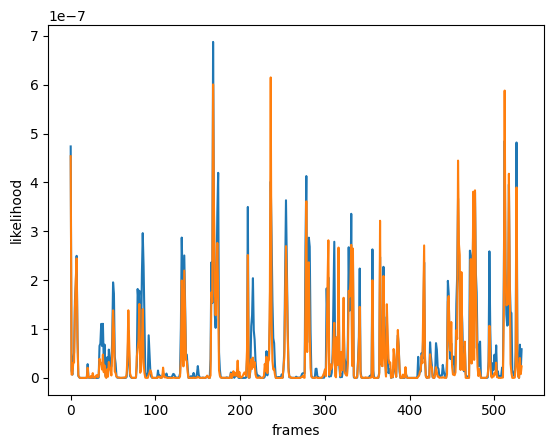

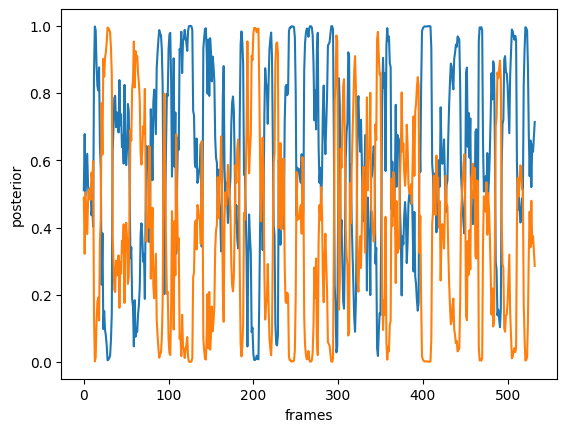

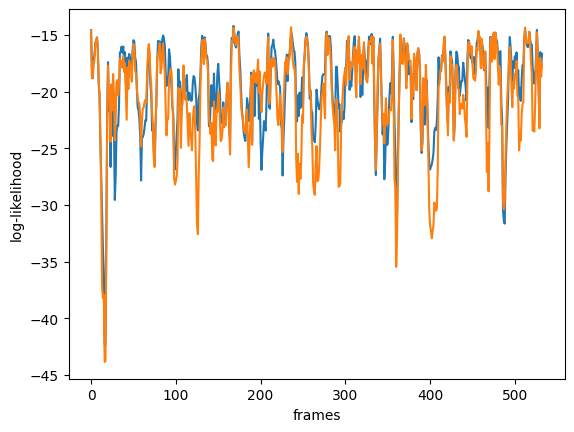

466.5658726494803


In [45]:
#train models, eval. likelihoods
rvf_m = sts.multivariate_normal(np.mean(train_m, axis=1), np.cov(train_m))
rvf_f = sts.multivariate_normal(np.mean(train_f, axis=1), np.cov(train_f))

lf_m = rvf_m.pdf(test_m[0].T)
lf_f = rvf_f.pdf(test_m[0].T)
plt.figure()
plt.plot(lf_m)
plt.plot(lf_f)
plt.xlabel('frames')
plt.ylabel('likelihood')
plt.show()

plt.figure()
plt.plot(lf_m/(lf_m+lf_f))
plt.plot(lf_f/(lf_m+lf_f))
plt.xlabel('frames')
plt.ylabel('posterior')
plt.show()

plt.figure()
plt.plot(np.log(lf_m))
plt.plot(np.log(lf_f))
plt.xlabel('frames')
plt.ylabel('log-likelihood')
plt.show()

print(sum(np.log(lf_m))-sum(np.log(lf_f)))

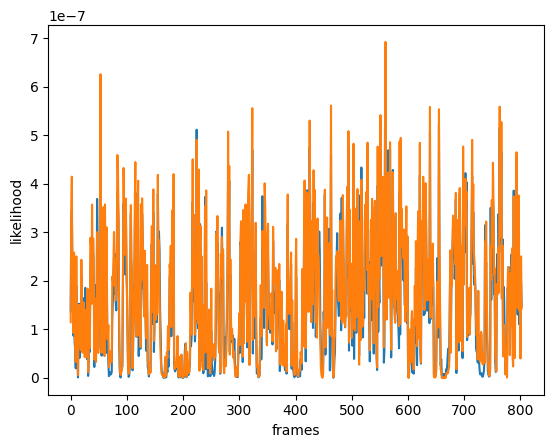

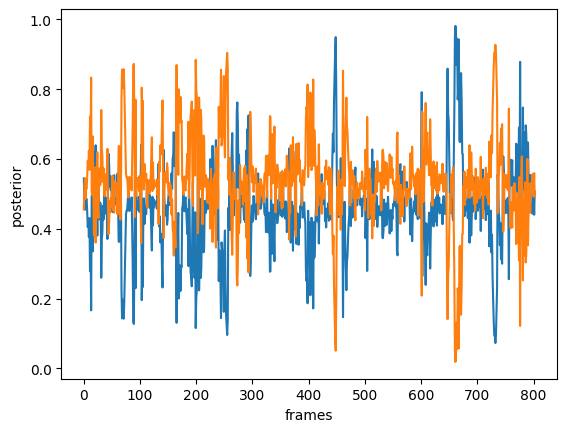

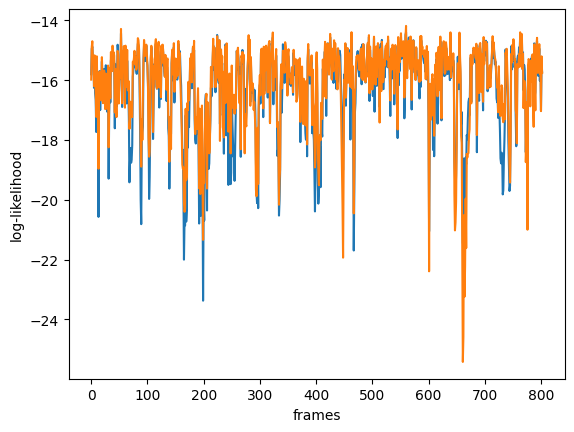

-129.12992611046502


In [46]:
lf_m = rvf_m.pdf(test_f[0].T)
lf_f = rvf_f.pdf(test_f[0].T)
plt.figure()
plt.plot(lf_m)
plt.plot(lf_f)
plt.xlabel('frames')
plt.ylabel('likelihood')
plt.show()

plt.figure()
plt.plot(lf_m/(lf_m+lf_f))
plt.plot(lf_f/(lf_m+lf_f))
plt.xlabel('frames')
plt.ylabel('posterior')
plt.show()

plt.figure()
plt.plot(np.log(lf_m))
plt.plot(np.log(lf_f))
plt.xlabel('frames')
plt.ylabel('log-likelihood')
plt.show()

print(sum(np.log(lf_m))-sum(np.log(lf_f)))

#### Q: Does the full covariance matrix give better results?

### 2.4   Calculation of the scores over all utterances


male
[np.float64(251.54693095807488), np.float64(338.8603406341008), np.float64(458.38359352583575), np.float64(654.912963056373), np.float64(179.96748866737926), np.float64(687.025266326109), np.float64(663.2872831392433), np.float64(532.552549880098), np.float64(256.0108744645222), np.float64(28.500652211008855)]
accuracy: 1.0



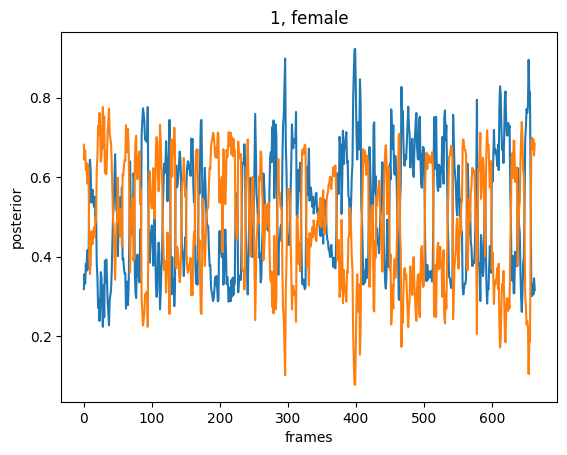

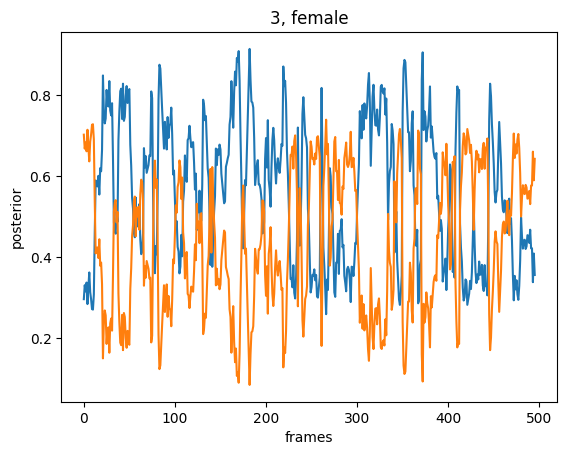

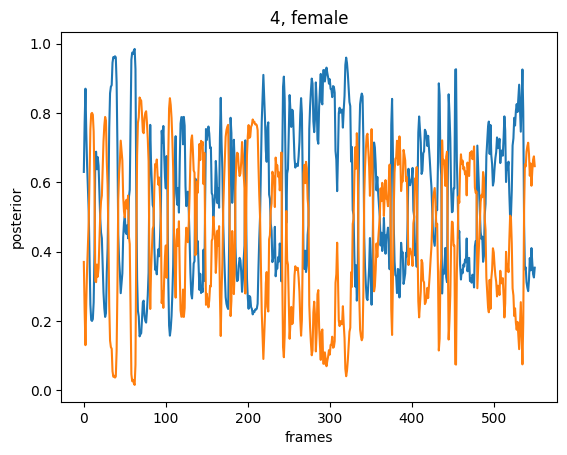

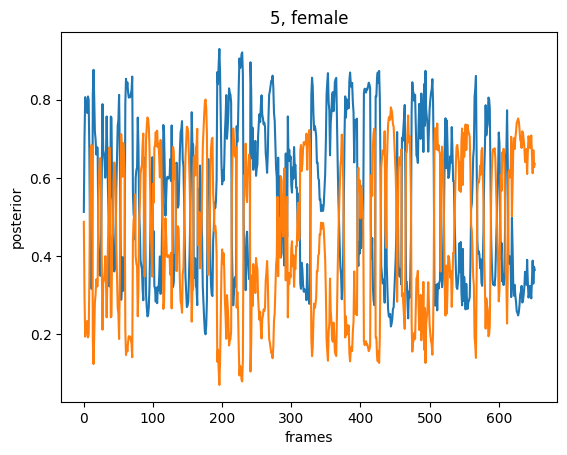

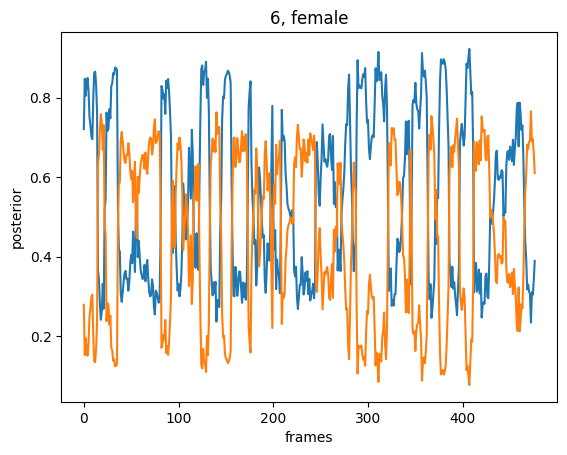

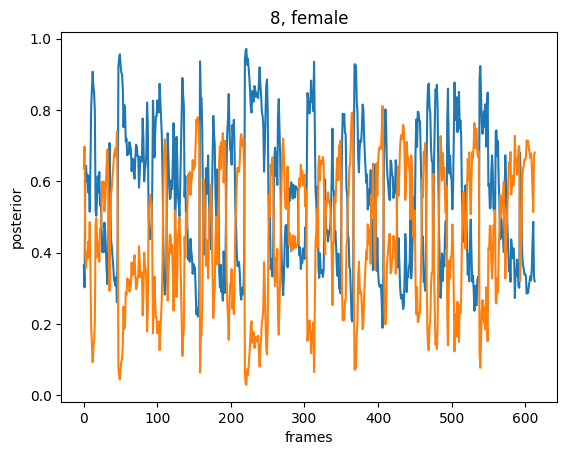

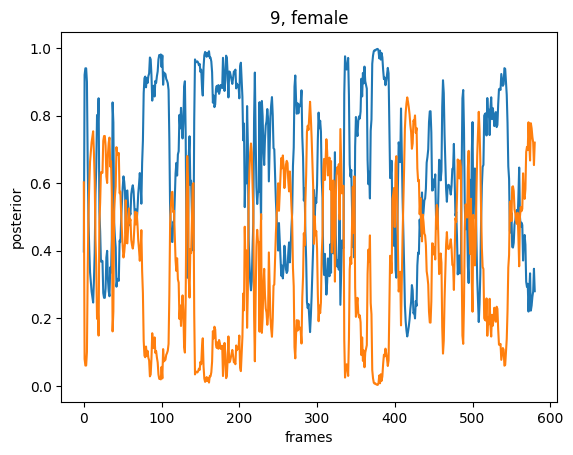

female
[np.float64(-538.7566016935743), np.float64(41.86945919763639), np.float64(-54.46809582033893), np.float64(154.7367461698941), np.float64(171.0605692084173), np.float64(161.64643945161333), np.float64(132.51897102868315), np.float64(-300.3093612232369), np.float64(197.47888355262512), np.float64(481.45444626885364)]
accuracy: 0.3


In [48]:
for tst_utterances, class_label, class_name in zip([test_m, test_f], [1,-1], ['male', 'female']):
    scores = []
    print()

    for i, tst in enumerate(tst_utterances):
        l_m = rv_m.pdf(tst.T)
        l_f = rv_f.pdf(tst.T)
        score = sum(np.log(l_m))-sum(np.log(l_f))
        scores.append(score)
        if class_label*score < 0: # shows posterior probabilities of badly classified samples
            plt.figure()
            plt.plot(l_m/(l_m+l_f))
            plt.plot(l_f/(l_m+l_f))
            plt.title(f'{i}, {class_name}')
            plt.xlabel('frames')
            plt.ylabel('posterior')
            plt.show()
    print(class_name)
    print(scores)
    print('accuracy:', np.mean(class_label*np.array(scores) > 0))

### 2.5 BONUS: Classification of multimodal Gaussian mixture models GMM
In the last exaercise, we build a multi-modal Gaussian mixture model. We have multiple Gaussians added up together, each with its own weights (the sum of the weights must be 1).
$$
p\left(\mathbf{x}\right) = \sum_{c=1}^C w_c \mathcal{N}\left(\mathbf{x}|\mathbf{\mu},\mathbf{\Sigma}\right) ; \sum_{c=1}^C w_c = 1,
$$

where $C$ is the number of components, $w_c$ are the weights, $\mathbf{μ}_c$ is the mean values vector and $\mathbf{\Sigma}_c$ is the covariance matrix (more in the lecture “9.Rozpoznávání HMM”).
We don't know the number of vertices (modus) as in the example in Ex.1, so we start using a single Gaussian and then we split them several times. We train the model (function "dgmixtrain") every time before the splitting (function "split_mix"), until we get the same number of components. We use the diagonal covariance matrix $\mathbf{\Sigma}_c$ because we don't have enough data to use a full covariance matrix.
To train a GMM the Expectation Maximization algorithm is used.

1) Train the model "male" on one gaussian
2) Split it in two
3) Implement the EM algorithm
4) Test the model
5) Evaluate the score


In [49]:
def split_mix(weights, mus, sigmas):
    new_w = [0]*len(weights)*2
    new_m = [0]*len(mus)*2
    new_s = [0]*len(sigmas)*2
    for i in range(len(weights)):
        aux = np.sqrt(sigmas[i])
        new_w[2*i], new_w[2*i+1] = weights[i]/2, weights[i]/2
        new_m[2*i], new_m[2*i+1] = mus[i] + 0.2*aux, mus[i] - 0.2*aux
        new_s[2*i], new_s[2*i+1] = sigmas[i], sigmas[i]
    return new_w, new_m, new_s

def dgmixtrain(x, pis, mus, sigmas):
    # taken from Lukas Burget's BAYa class
    #E-step
    log_p_xz = []
    for mu, sigma, pi in zip(mus, sigmas, pis):
        log_p_xz.append(sts.multivariate_normal.logpdf(x.T, mu, sigma) + np.log(pi))
    log_p_xz = np.array(log_p_xz).T
    log_p_x = np.log(np.sum(np.exp(log_p_xz), axis=1, keepdims=True))
    gammas = np.exp(log_p_xz - log_p_x)
    #M-step
    Nc = gammas.sum(axis=0)

    mus =  x.dot(gammas) / Nc
    sigmas =  (x**2).dot(gammas) / Nc - mus**2
    pis = Nc / Nc.sum()
    return pis,mus.T,sigmas.T

def gmm_pdf(x, mus, sigmas, pis):
    return sum([sts.multivariate_normal.pdf(x, mu, sigma) * pi for mu, sigma, pi in zip(mus, sigmas, pis)])


In [50]:
#play with these numbers
splits = 4
iters_per_split = 100

# male model
WW_m, MM_m, EE_m = [1], [np.mean(train_m, axis=1)], [np.var(train_m, axis=1)]
for i in range(splits):
    WW_m, MM_m, EE_m = split_mix(WW_m, MM_m, EE_m)
    for j in range(iters_per_split):
        WW_m, MM_m, EE_m = dgmixtrain(train_m, WW_m, MM_m, EE_m)
# female model
WW_f, MM_f, EE_f = [1], [np.mean(train_f, axis=1)], [np.var(train_f, axis=1)]
for i in range(splits):
    WW_f, MM_f, EE_f = split_mix(WW_f, MM_f, EE_f)
    for j in range(iters_per_split):
        WW_f, MM_f, EE_f = dgmixtrain(train_f, WW_f, MM_f, EE_f)


        scores = []
for tst in test_m:
    l_m = gmm_pdf(tst.T, MM_m, EE_m, WW_m)
    l_f = gmm_pdf(tst.T, MM_f, EE_f, WW_f)
    scores.append(sum(np.log(l_m))-sum(np.log(l_f)))
print(f'male splits {splits} iters {iters_per_split} acc {np.mean(np.array(scores) > 0)*100}')

scores = []
for tst in test_f:
    l_m = gmm_pdf(tst.T, MM_m, EE_m, WW_m)
    l_f = gmm_pdf(tst.T, MM_f, EE_f, WW_f)
    scores.append(sum(np.log(l_m))-sum(np.log(l_f)))
print(f'female splits {splits} iters {iters_per_split} acc {np.mean(np.array(scores) < 0)*100}')


male splits 4 iters 100 acc 100.0
female splits 4 iters 100 acc 90.0


#### Q: Try to do the same on the female dataset.
#### Q: Which classifier is better? The one with single gaussian and full covariance matrix, or the multimodal one?
#### Q: Try to add other gaussian, why does the score start to get worse?

### 2.6   Bonus: GMM from scikit.learn library

In [51]:
def score(dist1, dist2, data):
    scores = []
    for tst in data:
        l_1 = dist1.score(tst.T)
        l_2 = dist2.score(tst.T)
        scores.append(l_1-l_2)
    return np.mean(np.array(scores) > 0)

# https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
nb_com = 2
gmm_diag_m = GaussianMixture(n_components=nb_com, covariance_type='diag').fit(train_m.T)
gmm_diag_f = GaussianMixture(n_components=nb_com, covariance_type='diag').fit(train_f.T)

for scikit_m in gmm_diag_m.means_:
    print('scikit', np.sqrt(np.sum(scikit_m**2)))
    for our_m in MM_m:
        print('our', np.sqrt(np.sum(our_m**2)))
        print(f'eukl_dist: {np.sqrt(np.sum((scikit_m - our_m)**2))}')
    print()
gmm_full_m = GaussianMixture(n_components=nb_com, covariance_type='full').fit(train_m.T)
gmm_full_f = GaussianMixture(n_components=nb_com, covariance_type='full').fit(train_f.T)

vbgmm_full_m = BayesianGaussianMixture(n_components=nb_com, covariance_type='full').fit(train_m.T)
vbgmm_full_f = BayesianGaussianMixture(n_components=nb_com, covariance_type='full').fit(train_f.T)

vbgmm_diag_m = BayesianGaussianMixture(n_components=nb_com, covariance_type='diag').fit(train_m.T)
vbgmm_diag_f = BayesianGaussianMixture(n_components=nb_com, covariance_type='diag').fit(train_f.T)


scikit 65.46856765550926
our 52.370536517208265
eukl_dist: 13.832692332822129
our 50.50568191089372
eukl_dist: 16.138397788376803
our 65.80599911249277
eukl_dist: 6.791696972766659
our 66.98736347004342
eukl_dist: 3.191022081307643
our 66.57445411456729
eukl_dist: 4.4736550073249255
our 70.1863193196734
eukl_dist: 7.885653866589234
our 68.44472804892317
eukl_dist: 4.245985586753958
our 70.03460304148017
eukl_dist: 10.616272092772657
our 77.98859292835589
eukl_dist: 13.623700298357976
our 80.66399726822976
eukl_dist: 16.139948662954076
our 79.24846131434165
eukl_dist: 14.423307077304841
our 78.69477869622398
eukl_dist: 14.364709005213003
our 83.20976096082077
eukl_dist: 19.389393720552498
our 86.18023476331001
eukl_dist: 22.796883731780788
our 84.19360946773331
eukl_dist: 21.094656756172924
our 87.2037589883222
eukl_dist: 24.30144381251266

scikit 80.33430737033555
our 52.370536517208265
eukl_dist: 30.008139723623874
our 50.50568191089372
eukl_dist: 30.90498293891159
our 65.805999112492

In [52]:
print('GMM diag')
print('male', score(gmm_diag_m, gmm_diag_f, test_m))
print('female', score(gmm_diag_f, gmm_diag_m, test_f))

print('GMM full')
print('male', score(gmm_full_m, gmm_full_f, test_m))
print('female', score(gmm_full_f, gmm_full_m, test_f))

print('VBGMM diag')
print('male', score(vbgmm_diag_m, vbgmm_diag_f, test_m))
print('female', score(vbgmm_diag_f, vbgmm_diag_m, test_f))

print('VBGMM full')
print('male', score(vbgmm_full_m, vbgmm_full_f, test_m))
print('female', score(vbgmm_full_f, vbgmm_full_m, test_f))


GMM diag
male 1.0
female 0.7
GMM full
male 1.0
female 0.7
VBGMM diag
male 1.0
female 0.7
VBGMM full
male 1.0
female 0.7
